In [5]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
train_dataset = torchvision.datasets.FashionMNIST('./data/', download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST('./data/', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



내려받은 데이터를 메모리로 불러오기 위해 데이터로더에 전달한다.

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

분류에 사용될 클래스 정의

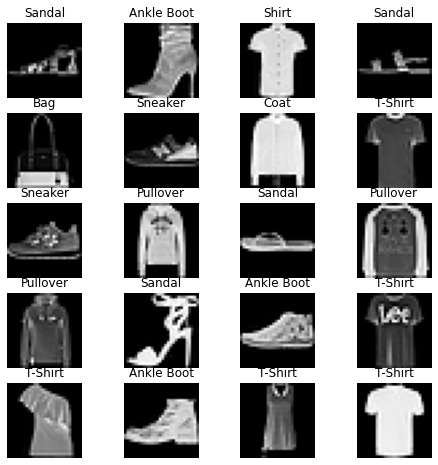

In [8]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

### 심층 신경망 모델 생성

In [9]:
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        
    def forward(self, input_data):
        x = input_data.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 파라미터 정의

In [10]:
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


### 모델 학습

In [15]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

In [16]:
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
                
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
                
        if not (count % 500):
            print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5090638995170593, Accuracy: 84.79999542236328%
Iteration: 1000, Loss: 0.4813261330127716, Accuracy: 85.13999938964844%
Iteration: 1500, Loss: 0.34314581751823425, Accuracy: 85.1199951171875%
Iteration: 2000, Loss: 0.39172059297561646, Accuracy: 85.5199966430664%
Iteration: 2500, Loss: 0.26634788513183594, Accuracy: 85.9000015258789%
Iteration: 3000, Loss: 0.3169247806072235, Accuracy: 86.72000122070312%


최종 적확도가 86%정도 나온다. 이제 합성곱 신경망을 생성해보자.

In [17]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

1. nn.Sequential을 사용하면 __init__()에서 사용할 네트워크 모델들을 정의해 줄 뿐만 아니라 forward() 함수에서 구현될 순전파를 계층 형태로 좀 더 가독성이 뛰어난 코드로 작성할 수 있다. 즉, nn.Sequential은 계층을 차례로 쌓을 수 있도록 Wx+b와 같은 수식과 활성화 함수를 연결해 주는 역할을 한다. 정리하면 nn.Sequential은 여러 개의 계층을 하나의 컨테이너에 구현하는 방법이다.

2. 합성곱층은 합성곱 연산을 통해서 이미지의 특징을 추출한다. 파라미터는 다음과 같다.
* in_channels : 입력 채널의 수를 의미한다. 흑백 이미지는 1, RGB 값을 가진 이미지는 3을 가진 경우가 많다.
* out_channels : 출력 채널의 수를 의미한다.
* kernel_size : 커널 크기를 의미하며 필터라고도 한다. 커널은 이미지 특징을 찾아내기 위한 공용 파라미터이며, CNN에서 학습 대상은 필터 파라미터가 된다. 커널은 입력 데이터를 스트라이드 간격으로 순회하면서 합성곱을 계산한다.  참고로 kernel_size=3이라고 했을 때, 커널의 크기는 (3, 3)으로 정사각형을 의미하며 (3, 5)처럼 지정할 수도 있다.
* padding : 패딩 크기를 의미하는 것으로 출력 크기를 조정하기 위해 입력 데이터 주위에 0을 채운다. 패딩 값이 클수록 출력 크기도 커진다.
3. BatchNorm2d는 학습 과정에서 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용하여 정규화하는 것을 의미한다.
4. 

In [18]:
model = FashionCNN()
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)
